In [1]:
# USEFUL WHEN RUNNING ON CLUSTER
import sys
!pip install torch torchvision torchtext pytorch_lightning tensorboard matplotlib tqdm datetime time 

ERROR: Could not find a version that satisfies the requirement time (from versions: none)
ERROR: No matching distribution found for time


In [2]:
!nvidia-smi

Thu Jan 12 14:06:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 455.23.05    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:86:00.0 Off |                  Off |
| N/A   35C    P0    30W / 250W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import torch
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.nn import BCELoss
from torch.nn import MSELoss
from torch.nn import functional as F

from torch.optim import Adam
from torch.optim import SGD
from torch.optim.lr_scheduler import CyclicLR
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import datetime

from src.model import UNet
from src.dataloader import LandCoverData

%load_ext autoreload
%autoreload 2

In [10]:
#path="../"
#path="/scratch/izar/damiani/"
path="/scratch/izar/nkaltenr/"

train_dataset = LandCoverData(path, split="train", ignore_last_number=11, use_augmented=False)
val_dataset = LandCoverData(path, split="val")

In [11]:
BATCH_SIZE = 2

# num_workers 8 default but 2 on colab
train_dl = DataLoader(train_dataset, BATCH_SIZE, True)
val_dl = DataLoader(val_dataset, BATCH_SIZE, False, drop_last=True)

In [12]:
INPUT_IMAGE_HEIGHT=200
INPUT_IMAGE_WIDTH=200

DEVICE = "cuda"
#DEVICE = "cpu"
INIT_LR = 0.001
INIT_MOMENTUM = 0.9

In [13]:
focal_loss = torch.hub.load(
	'adeelh/pytorch-multi-class-focal-loss',
	model='focal_loss',
	alpha=None,
	gamma=2,
	reduction='mean',
	device=DEVICE,
	dtype=torch.float32,
	force_reload=False
)

Using cache found in /home/nkaltenr/.cache/torch/hub/adeelh_pytorch-multi-class-focal-loss_master


In [14]:
# From https://github.com/Mr-TalhaIlyas/Loss-Functions-Package-Tensorflow-Keras-PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
#PyTorch
#Dice Loss
ALPHA = 0.5
BETA = 0.5
#Try also
#ALPHA = 0.3
#BETA = 0.7

GAMMA = 2

class FocalTverskyLoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalTverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA, gamma=GAMMA):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        #TP = (inputs * targets).sum()    
        #FP = ((1-targets) * inputs).sum()
        #FN = (targets * (1-inputs)).sum()
        TP = torch.sum(targets * inputs, dim=(0, 2, 3))
        FN = torch.sum(targets * (1-inputs), dim=(0, 2, 3))
        FP = torch.sum((1-targets) * inputs, dim=(0, 2, 3))
        
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = (1 - Tversky)**gamma
                       
        return FocalTversky

In [15]:
# from https://stackoverflow.com/questions/65125670/implementing-multiclass-dice-loss-function
import torch
import torch.nn as nn
import torch.nn.functional as F

def dice_coef_8cat(y_true, y_pred, smooth=1e-7):
    '''
    Dice coefficient for 8 categories.
    Pass to model as metric during compile statement
    '''
    y_true_f = torch.flatten(F.one_hot(y_true.to(torch.int64), num_classes=8)[...,:])
    y_pred_f = torch.flatten(y_pred[...,:])
    intersect = torch.sum(y_true_f * y_pred_f, axis=-1)
    denom = torch.sum(y_true_f + y_pred_f, axis=-1)
    return torch.mean((2. * intersect / (denom + smooth)))

def dice_coef_8cat_loss(y_true, y_pred):
    '''
    Dice loss to minimize. Pass to model as loss during compile statement
    '''
    return 1 - dice_coef_8cat(y_true, y_pred)

In [16]:
class mIoULoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True, n_classes=2):
        super(mIoULoss, self).__init__()
        self.classes = n_classes

    def to_one_hot(self, tensor):
        n,h,w = tensor.size()
        one_hot = torch.zeros(n,self.classes,h,w).to(tensor.device).scatter_(1,tensor.view(n,1,h,w),1)
        return one_hot

    def forward(self, inputs, target):
        # inputs => N x Classes x H x W
        # target_oneHot => N x Classes x H x W

        N = inputs.size()[0]

        # predicted probabilities for each pixel along channel
        inputs = F.softmax(inputs,dim=1)
        
        # Numerator Product
        target_oneHot = self.to_one_hot(target)
        inter = inputs * target_oneHot
        ## Sum over all pixels N x C x H x W => N x C
        inter = inter.view(N,self.classes,-1).sum(2)

        #Denominator 
        union= inputs + target_oneHot - (inputs*target_oneHot)
        ## Sum over all pixels N x C x H x W => N x C
        union = union.view(N,self.classes,-1).sum(2)

        loss = inter/union

        ## Return average loss over classes and batch
        return 1-loss.mean()

In [17]:
#weight_ce = [1., 3., 3.1, 14., 7., 3.3, 0.9, 1.]
#class_weights_ce = torch.FloatTensor(weight_ce).to(DEVICE)
#ce = CrossEntropyLoss(weight=class_weights_ce)
ce = CrossEntropyLoss()

#INIT_ALPHA = 10.0
#INIT_GAMMA = 2.0
#ml = MixedLoss(INIT_ALPHA, INIT_GAMMA)
#ftl = FocalTverskyLoss()
iou=mIoULoss(n_classes=8)


def UnetLoss(preds, targets):
    #print(f"preds : {preds.shape}")
    #print(f"targets : {targets.shape}")
    #loss = ce(preds, targets)
    #d_loss = dice_coef_8cat_loss(targets, preds)
    
    #loss = iou(preds, targets)
    
    #mix_loss = ce_loss + d_loss
    #ml_loss = ml
    loss = focal_loss(preds, targets)
    #ftl_loss = ftl(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return loss, acc

In [18]:
# initialize our UNet model
unet = UNet(nbClasses=8).to(DEVICE)
# initialize loss function and optimizer
lossFunc = UnetLoss
opt = SGD(unet.parameters(), lr=INIT_LR, momentum=INIT_MOMENTUM)
# calculate steps per epoch for training and validation set
trainSteps = len(train_dataset) // BATCH_SIZE
valSteps = len(val_dataset) // BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
bestValLoss = float('inf')
bestValAcc = -1

In [57]:
#H = torch.load('unet_model_2023-01-03_0:54_fl_2_loss_dict.pth', map_location=torch.device(DEVICE))

In [58]:
#unet.load_state_dict(torch.load('unet_model_epoch_200_fl_2_loss.pth', map_location=torch.device(DEVICE)))

In [19]:
name_for_save = "focal_loss_gamma_2"

In [20]:
# loop over epochs
NUM_EPOCHS = 100
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
    # set the model in training mode
    unet.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0
    totalTrainAcc = 0
    totalValAcc = 0
    # loop over the training set
    for (i, (x, y)) in enumerate(train_dl):
        # send the input to the device
        (x, y) = (x.to(DEVICE), y.to(DEVICE))
        # perform a forward pass and calculate the training loss
        pred = unet(x)
        y = y.to(torch.long)
        y = y.squeeze()
        
        loss, acc = lossFunc(pred, y)
        
        # first, zero out any previously accumulated gradients, then
        # perform backpropagation, and then update model parameters
        opt.zero_grad()
        loss.backward()
        opt.step()
        # add the loss to the total training loss so far
        totalTrainLoss += loss
        totalTrainAcc += acc
    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        unet.eval()
        # loop over the validation set
        for (x, y) in val_dl:
            # send the input to the device
            (x, y) = (x.to(DEVICE), y.to(DEVICE))
            # make the predictions and calculate the validation loss
            pred = unet(x)
            #pred=pred.to(torch.float32)
            y = y.to(torch.long)
            y = y.squeeze()
            
            loss, acc = lossFunc(pred, y)
            totalValLoss += loss
            totalValAcc += acc
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps
    avgTrainAcc = totalTrainAcc / trainSteps
    avgValAcc = totalValAcc / valSteps
    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["val_loss"].append(avgValLoss.cpu().detach().numpy())
    H["train_acc"].append(avgTrainAcc.cpu().detach().numpy())
    H["val_acc"].append(avgValAcc.cpu().detach().numpy())
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
    print("Train loss: {:.6f}, Validation loss: {:.4f}".format(
      avgTrainLoss, avgValLoss))
    print("Train acc: {:.6f}, Validation acc: {:.4f}".format(
      avgTrainAcc, avgValAcc))
    # Save the best model (the one that has the lowest loss for validation)
    if (bestValLoss == -1) or (bestValLoss > avgValLoss):
        bestValLoss = avgValLoss
        print("best loss => saving")
        torch.save(unet.state_dict(), f'best_model_{name_for_save}_loss.pth')
    if (bestValAcc < avgValAcc):
        bestValAcc = avgValAcc
        print("best acc => saving")
        torch.save(unet.state_dict(), f'best_model_acc_{name_for_save}_loss.pth')
    if ((e+1)%50 == 0):
        epoch_name = e+1
        print("SAVING")
        torch.save(unet.state_dict(), f"unet_model_epoch_{epoch_name}_{name_for_save}_loss.pth")
        torch.save(H, f"unet_model_epoch_{epoch_name}_{name_for_save}_H.pth")
        
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] training the network...


  0%|                                                   | 0/100 [00:00<?, ?it/s]

[INFO] EPOCH: 1/100
Train loss: 0.894132, Validation loss: 0.9493
Train acc: 0.503707, Validation acc: 0.5195
best loss => saving
best acc => saving


  1%|▍                                       | 1/100 [02:36<4:17:51, 156.27s/it]

[INFO] EPOCH: 2/100
Train loss: 0.693763, Validation loss: 0.7529
Train acc: 0.574036, Validation acc: 0.5696
best loss => saving
best acc => saving


  2%|▊                                       | 2/100 [04:57<4:00:44, 147.39s/it]

[INFO] EPOCH: 3/100
Train loss: 0.603599, Validation loss: 0.8633
Train acc: 0.601360, Validation acc: 0.5832
best acc => saving


  4%|█▌                                      | 4/100 [09:43<3:51:26, 144.65s/it]

[INFO] EPOCH: 4/100
Train loss: 0.544070, Validation loss: 0.9215
Train acc: 0.616906, Validation acc: 0.5325
[INFO] EPOCH: 5/100
Train loss: 0.515252, Validation loss: 0.8652
Train acc: 0.628037, Validation acc: 0.6129
best acc => saving


  6%|██▍                                     | 6/100 [14:33<3:46:28, 144.56s/it]

[INFO] EPOCH: 6/100
Train loss: 0.494883, Validation loss: 0.9173
Train acc: 0.638657, Validation acc: 0.5724


  7%|██▊                                     | 7/100 [16:57<3:43:49, 144.41s/it]

[INFO] EPOCH: 7/100
Train loss: 0.469939, Validation loss: 0.8770
Train acc: 0.650411, Validation acc: 0.5232
[INFO] EPOCH: 8/100
Train loss: 0.452783, Validation loss: 0.6707
Train acc: 0.660937, Validation acc: 0.6096
best loss => saving


  9%|███▌                                    | 9/100 [21:45<3:38:35, 144.12s/it]

[INFO] EPOCH: 9/100
Train loss: 0.439453, Validation loss: 0.7919
Train acc: 0.663409, Validation acc: 0.5755


 10%|███▉                                   | 10/100 [24:09<3:35:52, 143.91s/it]

[INFO] EPOCH: 10/100
Train loss: 0.427965, Validation loss: 0.7946
Train acc: 0.670814, Validation acc: 0.5951


 11%|████▎                                  | 11/100 [26:32<3:33:09, 143.71s/it]

[INFO] EPOCH: 11/100
Train loss: 0.420484, Validation loss: 0.7255
Train acc: 0.675485, Validation acc: 0.5784
[INFO] EPOCH: 12/100
Train loss: 0.406614, Validation loss: 0.6099
Train acc: 0.682197, Validation acc: 0.6211
best loss => saving
best acc => saving


 13%|█████                                  | 13/100 [31:18<3:28:15, 143.62s/it]

[INFO] EPOCH: 13/100
Train loss: 0.395711, Validation loss: 0.8446
Train acc: 0.688038, Validation acc: 0.5359
[INFO] EPOCH: 14/100
Train loss: 0.387271, Validation loss: 0.6726
Train acc: 0.692757, Validation acc: 0.6562
best acc => saving


 15%|█████▊                                 | 15/100 [36:02<3:22:27, 142.91s/it]

[INFO] EPOCH: 15/100
Train loss: 0.391234, Validation loss: 0.6823
Train acc: 0.689185, Validation acc: 0.6228


 16%|██████▏                                | 16/100 [38:22<3:18:44, 141.96s/it]

[INFO] EPOCH: 16/100
Train loss: 0.378086, Validation loss: 0.7392
Train acc: 0.697921, Validation acc: 0.5540


 17%|██████▋                                | 17/100 [40:44<3:16:12, 141.83s/it]

[INFO] EPOCH: 17/100
Train loss: 0.369140, Validation loss: 0.6684
Train acc: 0.703537, Validation acc: 0.5354


 18%|███████                                | 18/100 [43:06<3:14:04, 142.00s/it]

[INFO] EPOCH: 18/100
Train loss: 0.357197, Validation loss: 0.7255
Train acc: 0.710430, Validation acc: 0.6405


 19%|███████▍                               | 19/100 [45:26<3:10:56, 141.44s/it]

[INFO] EPOCH: 19/100
Train loss: 0.350823, Validation loss: 0.6481
Train acc: 0.712883, Validation acc: 0.6145


 20%|███████▊                               | 20/100 [47:46<3:07:47, 140.85s/it]

[INFO] EPOCH: 20/100
Train loss: 0.344460, Validation loss: 0.7101
Train acc: 0.719852, Validation acc: 0.6081


 21%|████████▏                              | 21/100 [50:05<3:04:58, 140.48s/it]

[INFO] EPOCH: 21/100
Train loss: 0.340707, Validation loss: 0.7047
Train acc: 0.721898, Validation acc: 0.6204


 22%|████████▌                              | 22/100 [52:25<3:02:20, 140.27s/it]

[INFO] EPOCH: 22/100
Train loss: 0.328398, Validation loss: 0.7337
Train acc: 0.728415, Validation acc: 0.5693


 23%|████████▉                              | 23/100 [54:45<2:59:49, 140.13s/it]

[INFO] EPOCH: 23/100
Train loss: 0.325092, Validation loss: 0.7811
Train acc: 0.732737, Validation acc: 0.5868
[INFO] EPOCH: 24/100
Train loss: 0.318883, Validation loss: 0.5958
Train acc: 0.734779, Validation acc: 0.6590
best loss => saving
best acc => saving


 25%|█████████▊                             | 25/100 [59:25<2:55:08, 140.11s/it]

[INFO] EPOCH: 25/100
Train loss: 0.304636, Validation loss: 0.7247
Train acc: 0.744157, Validation acc: 0.6161


 26%|█████████▌                           | 26/100 [1:01:45<2:52:43, 140.05s/it]

[INFO] EPOCH: 26/100
Train loss: 0.302586, Validation loss: 0.7633
Train acc: 0.746693, Validation acc: 0.5882


 27%|█████████▉                           | 27/100 [1:04:05<2:50:22, 140.04s/it]

[INFO] EPOCH: 27/100
Train loss: 0.292314, Validation loss: 0.6990
Train acc: 0.751218, Validation acc: 0.6051


 28%|██████████▎                          | 28/100 [1:06:25<2:47:52, 139.90s/it]

[INFO] EPOCH: 28/100
Train loss: 0.278356, Validation loss: 0.8649
Train acc: 0.761751, Validation acc: 0.5338


 29%|██████████▋                          | 29/100 [1:08:45<2:45:33, 139.91s/it]

[INFO] EPOCH: 29/100
Train loss: 0.271059, Validation loss: 0.6738
Train acc: 0.766131, Validation acc: 0.5830


 30%|███████████                          | 30/100 [1:11:04<2:43:06, 139.80s/it]

[INFO] EPOCH: 30/100
Train loss: 0.264467, Validation loss: 0.6738
Train acc: 0.771075, Validation acc: 0.6558


 31%|███████████▍                         | 31/100 [1:13:24<2:40:51, 139.88s/it]

[INFO] EPOCH: 31/100
Train loss: 0.245079, Validation loss: 0.8685
Train acc: 0.781439, Validation acc: 0.5618


 32%|███████████▊                         | 32/100 [1:15:44<2:38:29, 139.84s/it]

[INFO] EPOCH: 32/100
Train loss: 0.238993, Validation loss: 0.8718
Train acc: 0.787099, Validation acc: 0.5670


 33%|████████████▏                        | 33/100 [1:18:05<2:36:34, 140.22s/it]

[INFO] EPOCH: 33/100
Train loss: 0.238741, Validation loss: 0.6562
Train acc: 0.790520, Validation acc: 0.6257


 34%|████████████▌                        | 34/100 [1:20:36<2:37:45, 143.42s/it]

[INFO] EPOCH: 34/100
Train loss: 0.219724, Validation loss: 0.8099
Train acc: 0.801849, Validation acc: 0.5760


 35%|████████████▉                        | 35/100 [1:23:08<2:38:05, 145.93s/it]

[INFO] EPOCH: 35/100
Train loss: 0.205092, Validation loss: 0.6716
Train acc: 0.812025, Validation acc: 0.6451


 36%|█████████████▎                       | 36/100 [1:25:42<2:38:18, 148.41s/it]

[INFO] EPOCH: 36/100
Train loss: 0.191795, Validation loss: 1.0848
Train acc: 0.822828, Validation acc: 0.4784


 37%|█████████████▋                       | 37/100 [1:28:14<2:37:00, 149.54s/it]

[INFO] EPOCH: 37/100
Train loss: 0.189439, Validation loss: 0.9394
Train acc: 0.826762, Validation acc: 0.5098


 38%|██████████████                       | 38/100 [1:30:36<2:32:18, 147.39s/it]

[INFO] EPOCH: 38/100
Train loss: 0.179878, Validation loss: 0.9091
Train acc: 0.833293, Validation acc: 0.5246


 39%|██████████████▍                      | 39/100 [1:32:57<2:27:46, 145.36s/it]

[INFO] EPOCH: 39/100
Train loss: 0.174687, Validation loss: 1.2924
Train acc: 0.839854, Validation acc: 0.5231


 40%|██████████████▊                      | 40/100 [1:35:17<2:23:34, 143.58s/it]

[INFO] EPOCH: 40/100
Train loss: 0.155210, Validation loss: 0.8111
Train acc: 0.853985, Validation acc: 0.6074


 41%|███████████████▏                     | 41/100 [1:37:38<2:20:32, 142.92s/it]

[INFO] EPOCH: 41/100
Train loss: 0.153458, Validation loss: 1.4434
Train acc: 0.856433, Validation acc: 0.5494


 42%|███████████████▌                     | 42/100 [1:39:57<2:17:10, 141.90s/it]

[INFO] EPOCH: 42/100
Train loss: 0.135429, Validation loss: 1.1032
Train acc: 0.872598, Validation acc: 0.5194


 43%|███████████████▉                     | 43/100 [1:42:17<2:14:07, 141.18s/it]

[INFO] EPOCH: 43/100
Train loss: 0.127679, Validation loss: 0.7776
Train acc: 0.880035, Validation acc: 0.5882


 44%|████████████████▎                    | 44/100 [1:44:38<2:11:42, 141.11s/it]

[INFO] EPOCH: 44/100
Train loss: 0.128699, Validation loss: 1.0294
Train acc: 0.880268, Validation acc: 0.5028


 45%|████████████████▋                    | 45/100 [1:46:58<2:08:58, 140.70s/it]

[INFO] EPOCH: 45/100
Train loss: 0.114029, Validation loss: 0.8480
Train acc: 0.891479, Validation acc: 0.5718


 46%|█████████████████                    | 46/100 [1:49:17<2:06:12, 140.24s/it]

[INFO] EPOCH: 46/100
Train loss: 0.096818, Validation loss: 0.9826
Train acc: 0.907335, Validation acc: 0.5094


 47%|█████████████████▍                   | 47/100 [1:51:36<2:03:42, 140.04s/it]

[INFO] EPOCH: 47/100
Train loss: 0.093445, Validation loss: 0.9621
Train acc: 0.910607, Validation acc: 0.5936


 48%|█████████████████▊                   | 48/100 [1:53:56<2:01:14, 139.90s/it]

[INFO] EPOCH: 48/100
Train loss: 0.082035, Validation loss: 0.9427
Train acc: 0.920685, Validation acc: 0.5976


 49%|██████████████████▏                  | 49/100 [1:56:15<1:58:43, 139.68s/it]

[INFO] EPOCH: 49/100
Train loss: 0.086378, Validation loss: 0.8333
Train acc: 0.919732, Validation acc: 0.6380
[INFO] EPOCH: 50/100
Train loss: 0.085719, Validation loss: 1.0841
Train acc: 0.919852, Validation acc: 0.5227
SAVING


 51%|██████████████████▊                  | 51/100 [2:00:55<1:54:10, 139.81s/it]

[INFO] EPOCH: 51/100
Train loss: 0.081142, Validation loss: 0.9969
Train acc: 0.924508, Validation acc: 0.5233


 52%|███████████████████▏                 | 52/100 [2:03:14<1:51:42, 139.63s/it]

[INFO] EPOCH: 52/100
Train loss: 0.074110, Validation loss: 1.1244
Train acc: 0.930310, Validation acc: 0.5118


 53%|███████████████████▌                 | 53/100 [2:05:35<1:49:38, 139.98s/it]

[INFO] EPOCH: 53/100
Train loss: 0.071815, Validation loss: 1.1386
Train acc: 0.932322, Validation acc: 0.4938


 54%|███████████████████▉                 | 54/100 [2:07:55<1:47:14, 139.87s/it]

[INFO] EPOCH: 54/100
Train loss: 0.063783, Validation loss: 0.8958
Train acc: 0.939435, Validation acc: 0.5830
[INFO] EPOCH: 55/100
Train loss: 0.057881, Validation loss: 0.8836
Train acc: 0.943705, Validation acc: 0.6708
best acc => saving


 56%|████████████████████▋                | 56/100 [2:12:33<1:42:20, 139.57s/it]

[INFO] EPOCH: 56/100
Train loss: 0.059074, Validation loss: 1.0459
Train acc: 0.944600, Validation acc: 0.6011


 57%|█████████████████████                | 57/100 [2:14:53<1:40:05, 139.65s/it]

[INFO] EPOCH: 57/100
Train loss: 0.058352, Validation loss: 0.9345
Train acc: 0.945199, Validation acc: 0.6313


 58%|█████████████████████▍               | 58/100 [2:17:12<1:37:33, 139.36s/it]

[INFO] EPOCH: 58/100
Train loss: 0.053816, Validation loss: 1.0316
Train acc: 0.950322, Validation acc: 0.5387


 59%|█████████████████████▊               | 59/100 [2:19:31<1:35:10, 139.28s/it]

[INFO] EPOCH: 59/100
Train loss: 0.046231, Validation loss: 1.0443
Train acc: 0.956921, Validation acc: 0.5529


 60%|██████████████████████▏              | 60/100 [2:21:50<1:32:48, 139.20s/it]

[INFO] EPOCH: 60/100
Train loss: 0.039838, Validation loss: 1.0286
Train acc: 0.959596, Validation acc: 0.5620


 61%|██████████████████████▌              | 61/100 [2:24:09<1:30:23, 139.08s/it]

[INFO] EPOCH: 61/100
Train loss: 0.043760, Validation loss: 1.2103
Train acc: 0.958151, Validation acc: 0.5110


 62%|██████████████████████▉              | 62/100 [2:26:28<1:28:05, 139.09s/it]

[INFO] EPOCH: 62/100
Train loss: 0.035600, Validation loss: 1.0043
Train acc: 0.963342, Validation acc: 0.6166


 63%|███████████████████████▎             | 63/100 [2:28:49<1:26:03, 139.56s/it]

[INFO] EPOCH: 63/100
Train loss: 0.038277, Validation loss: 1.1112
Train acc: 0.962795, Validation acc: 0.5327


 64%|███████████████████████▋             | 64/100 [2:31:10<1:24:03, 140.10s/it]

[INFO] EPOCH: 64/100
Train loss: 0.034140, Validation loss: 1.1817
Train acc: 0.965237, Validation acc: 0.5527


 65%|████████████████████████             | 65/100 [2:33:29<1:21:34, 139.86s/it]

[INFO] EPOCH: 65/100
Train loss: 0.032745, Validation loss: 1.3322
Train acc: 0.966857, Validation acc: 0.5096


 66%|████████████████████████▍            | 66/100 [2:35:49<1:19:11, 139.74s/it]

[INFO] EPOCH: 66/100
Train loss: 0.032863, Validation loss: 0.9996
Train acc: 0.966625, Validation acc: 0.6059


 67%|████████████████████████▊            | 67/100 [2:38:08<1:16:47, 139.62s/it]

[INFO] EPOCH: 67/100
Train loss: 0.030614, Validation loss: 1.1296
Train acc: 0.968499, Validation acc: 0.5687


 68%|█████████████████████████▏           | 68/100 [2:40:28<1:14:31, 139.73s/it]

[INFO] EPOCH: 68/100
Train loss: 0.029419, Validation loss: 1.1629
Train acc: 0.969829, Validation acc: 0.5691


 69%|█████████████████████████▌           | 69/100 [2:42:47<1:12:04, 139.50s/it]

[INFO] EPOCH: 69/100
Train loss: 0.033113, Validation loss: 1.0652
Train acc: 0.967072, Validation acc: 0.5981


 70%|█████████████████████████▉           | 70/100 [2:45:06<1:09:37, 139.25s/it]

[INFO] EPOCH: 70/100
Train loss: 0.029104, Validation loss: 1.0679
Train acc: 0.970485, Validation acc: 0.5631


 71%|██████████████████████████▎          | 71/100 [2:47:26<1:07:24, 139.46s/it]

[INFO] EPOCH: 71/100
Train loss: 0.032303, Validation loss: 1.3197
Train acc: 0.967897, Validation acc: 0.4783


 72%|██████████████████████████▋          | 72/100 [2:49:51<1:05:53, 141.19s/it]

[INFO] EPOCH: 72/100
Train loss: 0.026663, Validation loss: 1.1174
Train acc: 0.972702, Validation acc: 0.5689


 73%|███████████████████████████          | 73/100 [2:52:32<1:06:13, 147.15s/it]

[INFO] EPOCH: 73/100
Train loss: 0.022765, Validation loss: 1.2052
Train acc: 0.975215, Validation acc: 0.5660


 74%|███████████████████████████▍         | 74/100 [2:54:52<1:02:53, 145.14s/it]

[INFO] EPOCH: 74/100
Train loss: 0.024717, Validation loss: 0.9252
Train acc: 0.973565, Validation acc: 0.6288


 75%|█████████████████████████████▎         | 75/100 [2:57:12<59:46, 143.44s/it]

[INFO] EPOCH: 75/100
Train loss: 0.025379, Validation loss: 1.0157
Train acc: 0.973863, Validation acc: 0.5609


 76%|█████████████████████████████▋         | 76/100 [2:59:32<56:57, 142.40s/it]

[INFO] EPOCH: 76/100
Train loss: 0.024839, Validation loss: 1.0748
Train acc: 0.974090, Validation acc: 0.6012


 77%|██████████████████████████████         | 77/100 [3:01:52<54:16, 141.60s/it]

[INFO] EPOCH: 77/100
Train loss: 0.029873, Validation loss: 1.0378
Train acc: 0.970575, Validation acc: 0.6244


 78%|██████████████████████████████▍        | 78/100 [3:04:19<52:34, 143.41s/it]

[INFO] EPOCH: 78/100
Train loss: 0.022562, Validation loss: 1.1212
Train acc: 0.975862, Validation acc: 0.6044


 79%|██████████████████████████████▊        | 79/100 [3:06:55<51:29, 147.10s/it]

[INFO] EPOCH: 79/100
Train loss: 0.020359, Validation loss: 1.1523
Train acc: 0.977544, Validation acc: 0.5804


 80%|███████████████████████████████▏       | 80/100 [3:09:56<52:27, 157.39s/it]

[INFO] EPOCH: 80/100
Train loss: 0.022125, Validation loss: 0.9510
Train acc: 0.977170, Validation acc: 0.6255


 81%|███████████████████████████████▌       | 81/100 [3:12:18<48:22, 152.76s/it]

[INFO] EPOCH: 81/100
Train loss: 0.018808, Validation loss: 1.1572
Train acc: 0.979035, Validation acc: 0.6008


 82%|███████████████████████████████▉       | 82/100 [3:14:38<44:37, 148.76s/it]

[INFO] EPOCH: 82/100
Train loss: 0.021386, Validation loss: 1.1360
Train acc: 0.977203, Validation acc: 0.5919


 83%|████████████████████████████████▎      | 83/100 [3:16:57<41:21, 145.98s/it]

[INFO] EPOCH: 83/100
Train loss: 0.020024, Validation loss: 1.3261
Train acc: 0.977572, Validation acc: 0.5210


 84%|████████████████████████████████▊      | 84/100 [3:19:19<38:36, 144.79s/it]

[INFO] EPOCH: 84/100
Train loss: 0.017769, Validation loss: 1.4648
Train acc: 0.979638, Validation acc: 0.5128


 85%|█████████████████████████████████▏     | 85/100 [3:21:41<35:56, 143.79s/it]

[INFO] EPOCH: 85/100
Train loss: 0.020171, Validation loss: 1.2938
Train acc: 0.978310, Validation acc: 0.5339


 86%|█████████████████████████████████▌     | 86/100 [3:24:02<33:23, 143.13s/it]

[INFO] EPOCH: 86/100
Train loss: 0.019036, Validation loss: 1.3940
Train acc: 0.979522, Validation acc: 0.4607


 87%|█████████████████████████████████▉     | 87/100 [3:26:21<30:44, 141.90s/it]

[INFO] EPOCH: 87/100
Train loss: 0.019146, Validation loss: 1.1529
Train acc: 0.978491, Validation acc: 0.6184


 88%|██████████████████████████████████▎    | 88/100 [3:28:41<28:13, 141.14s/it]

[INFO] EPOCH: 88/100
Train loss: 0.019810, Validation loss: 1.2523
Train acc: 0.978301, Validation acc: 0.5430


 89%|██████████████████████████████████▋    | 89/100 [3:31:00<25:45, 140.48s/it]

[INFO] EPOCH: 89/100
Train loss: 0.017160, Validation loss: 1.2087
Train acc: 0.980174, Validation acc: 0.5589


 90%|███████████████████████████████████    | 90/100 [3:33:19<23:21, 140.13s/it]

[INFO] EPOCH: 90/100
Train loss: 0.018789, Validation loss: 1.1769
Train acc: 0.979508, Validation acc: 0.5623


 91%|███████████████████████████████████▍   | 91/100 [3:35:40<21:02, 140.30s/it]

[INFO] EPOCH: 91/100
Train loss: 0.016902, Validation loss: 1.1350
Train acc: 0.980712, Validation acc: 0.5933


 92%|███████████████████████████████████▉   | 92/100 [3:38:03<18:49, 141.14s/it]

[INFO] EPOCH: 92/100
Train loss: 0.017781, Validation loss: 1.4863
Train acc: 0.980273, Validation acc: 0.5010


 93%|████████████████████████████████████▎  | 93/100 [3:40:27<16:35, 142.16s/it]

[INFO] EPOCH: 93/100
Train loss: 0.022871, Validation loss: 1.1378
Train acc: 0.976601, Validation acc: 0.5719


 94%|████████████████████████████████████▋  | 94/100 [3:43:00<14:32, 145.41s/it]

[INFO] EPOCH: 94/100
Train loss: 0.022050, Validation loss: 1.0565
Train acc: 0.976494, Validation acc: 0.5808


 95%|█████████████████████████████████████  | 95/100 [3:45:29<12:12, 146.43s/it]

[INFO] EPOCH: 95/100
Train loss: 0.025452, Validation loss: 1.1153
Train acc: 0.973531, Validation acc: 0.5369


 96%|█████████████████████████████████████▍ | 96/100 [3:47:50<09:39, 144.90s/it]

[INFO] EPOCH: 96/100
Train loss: 0.020442, Validation loss: 1.1989
Train acc: 0.978237, Validation acc: 0.5832


 97%|█████████████████████████████████████▊ | 97/100 [3:50:13<07:12, 144.24s/it]

[INFO] EPOCH: 97/100
Train loss: 0.016754, Validation loss: 1.2761
Train acc: 0.981081, Validation acc: 0.4972


 98%|██████████████████████████████████████▏| 98/100 [3:52:33<04:45, 142.86s/it]

[INFO] EPOCH: 98/100
Train loss: 0.014042, Validation loss: 1.1111
Train acc: 0.983213, Validation acc: 0.5597


 99%|██████████████████████████████████████▌| 99/100 [3:54:53<02:22, 142.11s/it]

[INFO] EPOCH: 99/100
Train loss: 0.014480, Validation loss: 1.1143
Train acc: 0.983355, Validation acc: 0.6156
[INFO] EPOCH: 100/100
Train loss: 0.013315, Validation loss: 1.0061
Train acc: 0.983929, Validation acc: 0.6264
SAVING


100%|██████████████████████████████████████| 100/100 [3:57:14<00:00, 142.34s/it]

[INFO] total time taken to train the model: 14234.40s


In [21]:
date = datetime.datetime.now()
date_ymd = date.date()
date_hm = f"{date.hour}:{date.minute}"

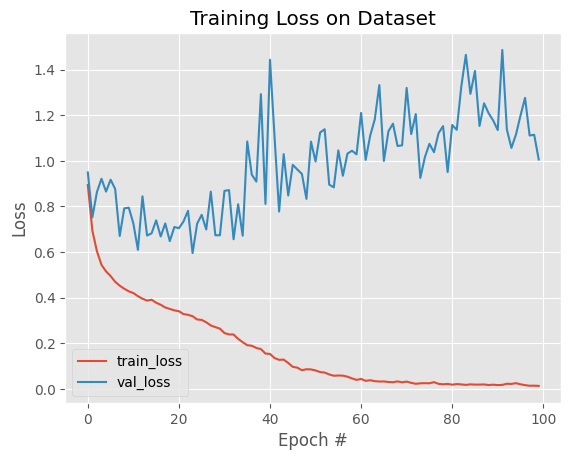

In [22]:
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(f"train_val_loss_{date_ymd}_{date_hm}_{name_for_save}_loss.png", bbox_inches='tight')

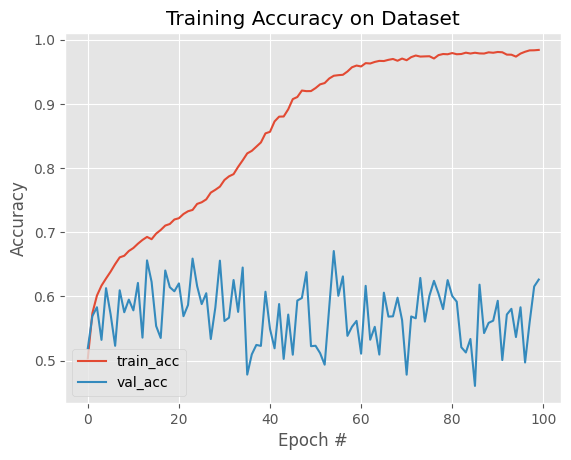

In [23]:
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig(f"train_val_acc_{date_ymd}_{date_hm}_{name_for_save}_loss.png", bbox_inches='tight')

In [24]:
torch.save(unet.state_dict(), f"unet_model_{date_ymd}_{date_hm}_{name_for_save}_loss.pth")
torch.save(unet, f"unet_model_{date_ymd}_{date_hm}_{name_for_save}_loss.pt")
torch.save(H, f"unet_model_{date_ymd}_{date_hm}_{name_for_save}_loss_dict.pth")